# GMM

### Getting Started

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage, dendrogram

import matplotlib.pyplot as plt
import seaborn as sns

### Import and Preprocess New Feature Engineered Dataset

In [3]:
df = pd.read_csv("../data/NewWordDifficulty.csv")
df.head()

,Word,Length,Log_Freq_HAL,I_Zscore,I_Mean_Accuracy,Vowels,Entropy,PoS,SentimentScore
0,a,1,16.18,-0.01,0.73,1,-0.000000,DT,0.0
1,aah,3,5.40,0.21,0.62,2,0.918296,JJ,0.0
2,aaron,5,9.29,-0.11,0.97,3,1.921928,NN,0.0
3,aback,5,5.96,0.11,0.45,2,1.921928,NN,0.0
4,abacus,6,6.24,0.65,0.47,3,2.251629,NN,0.0


In [4]:
df = df.drop('PoS', axis=1)

In [5]:
# # One hot encode PoS column
# encoder = OneHotEncoder(sparse_output=False)
# encoded_data = encoder.fit_transform(df[['PoS']])
# encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['PoS']))

# # Replace original PoS column
# df.drop('PoS', axis=1, inplace=True)
# df = pd.concat([df, encoded_df], axis=1)

In [6]:
df.set_index('Word', inplace=True)
df.head()

,Length,Log_Freq_HAL,I_Zscore,I_Mean_Accuracy,Vowels,Entropy,SentimentScore
Word,,,,,,,
a,1,16.18,-0.01,0.73,1,-0.000000,0.0
aah,3,5.40,0.21,0.62,2,0.918296,0.0
aaron,5,9.29,-0.11,0.97,3,1.921928,0.0
aback,5,5.96,0.11,0.45,2,1.921928,0.0
abacus,6,6.24,0.65,0.47,3,2.251629,0.0


### GMM

In [7]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)
scaled_features

array([[-2.84322901e+00,  4.17323203e+00, -3.13564869e-02, ...,
        -1.60793955e+00, -6.39046258e+00,  3.64611341e-02],
       [-2.03057885e+00, -3.23577986e-01,  4.43770274e-01, ...,
        -8.03215158e-01, -4.14123593e+00,  3.64611341e-02],
       [-1.21792869e+00,  1.29911134e+00, -2.47323196e-01, ...,
         1.50923555e-03, -1.68299061e+00,  3.64611341e-02],
       ...,
       [-8.11603611e-01,  5.44081089e-01,  1.84610223e-01, ...,
        -8.03215158e-01, -5.89881803e-02,  3.64611341e-02],
       [-1.21792869e+00, -2.57615443e+00, -3.55306551e-01, ...,
        -8.03215158e-01, -7.03251146e-01,  3.64611341e-02],
       [-1.62425377e+00, -2.57615443e+00, -5.92869932e-01, ...,
        -8.03215158e-01, -1.49176529e+00,  3.47714440e+00]])

In [ ]:
scaled_features.shape

In [ ]:
from sklearn.mixture import GaussianMixture

# Fit GMM to the data
gmm = GaussianMixture(n_components=2, covariance_type='tied')
gmm.fit(scaled_features)

# Predict clusters
labels = gmm.predict(scaled_features)

# Plot the data points with color-coded clusters
plt.scatter(scaled_features[:, 3], scaled_features[:, 2], c=labels, cmap='viridis', s=50, alpha=0.3)
plt.title('GMM Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()

In [ ]:
silhouette_score(scaled_features, labels)

In [ ]:
for idx, label in enumerate(labels):
    labels[idx] = 1 if label == 0 else 0

In [ ]:
import colorcet as cc
knn = KMeans(n_clusters=2)
knn_labels = knn.fit_predict(df)
kmeans_df = df
kmeans_df['Labels'] = knn_labels
grouped = kmeans_df.groupby('Labels')
palette = sns.color_palette(cc.glasbey, n_colors=2)

colors = pd.Categorical(df['Labels']).codes
colors = [palette[i] for i in colors]

plt.figure(figsize=(8, 6))
plt.scatter(kmeans_df['I_Mean_Accuracy'], kmeans_df['I_Zscore'], c=colors, label=df['Labels'], alpha=0.3)
plt.title('I_Mean_Accuracy vs I_Zscore')
plt.show()

In [ ]:
silhouette_score(scaled_features, knn_labels)

In [ ]:
from sklearn.metrics import mutual_info_score

mutual_info_score(labels, knn_labels)

In [ ]:
knn_labels

### Spectral Clustering

In [ ]:
# Apply PCA
n_components = 3
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_features)

comp = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, n_components + 1)])
comp.head()

In [ ]:
n_clusters = 3  # specify the number of clusters
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='rbf', n_neighbors=10, n_jobs=4)
cluster_labels = spectral_clustering.fit_predict(scaled_features)

In [ ]:
silhouette_score(scaled_features, cluster_labels)

In [8]:
from scipy import stats
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eigh
from sklearn.datasets import make_circles, make_moons
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans, SpectralClustering


def generate_graph_laplacian(df, nn):
    """Generate graph Laplacian from data."""
    # Adjacency/Affinity Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn)
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    return graph_laplacian 

In [ ]:
graph_laplacian = generate_graph_laplacian(df, nn=10)

eigenvals, eigenvcts = eigh(graph_laplacian)

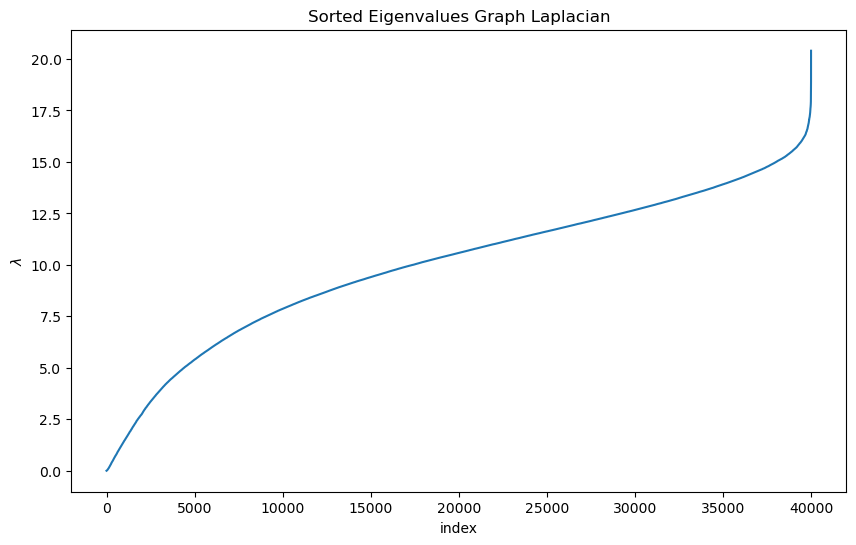

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(len(eigenvals)), y=eigenvals, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$');

In [18]:
zero_eigenvals_index = np.argwhere(abs(eigenvals) < 1e-5) # arbitrary number close to zero
zeroeigens = eigenvals[zero_eigenvals_index]
nzeros = len(zeroeigens)
zeroeigens

array([[1.6143621e-15]])

In [19]:
proj_df = pd.DataFrame(eigenvcts[:, zero_eigenvals_index.squeeze()])
proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
proj_df.head()

,v_0
0,-0.005001
1,-0.005001
2,-0.005001
3,-0.005001
4,-0.005001


In [20]:
inertias = []

k_candidates = [2, 3, 6, 12, 24]

for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(proj_df)
    inertias.append(k_means.inertia_)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\clust

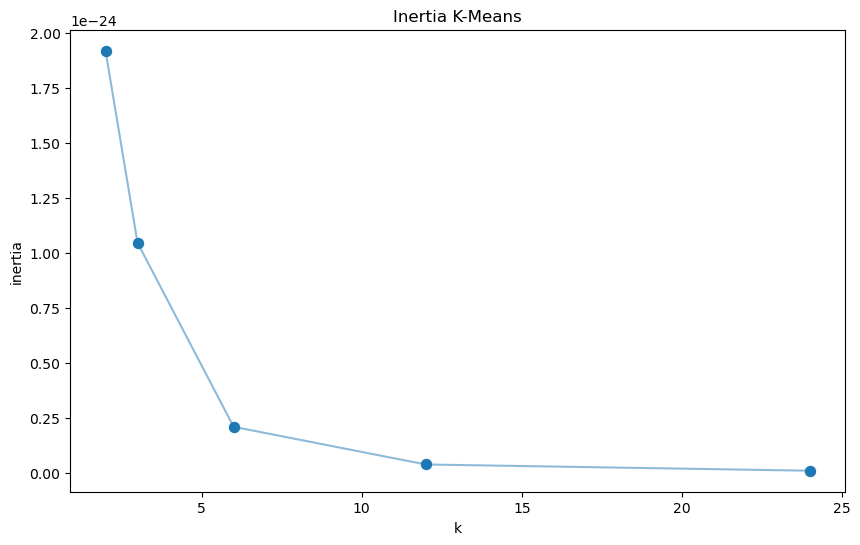

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=k_candidates, y = inertias, s=80, ax=ax)
sns.lineplot(x=k_candidates, y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');

In [15]:
proj_df.to_csv('../outputs/proj_df.csv',index=False)

In [22]:
clust = KMeans(n_clusters=6).fit_predict(proj_df)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [23]:
silhouette_score(df, clust)

-0.0001828422547400991